<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/1615614-Загрузка-данных-записки/Загрузка-данных-записки.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Serge3leo/temp-cola.git/HEAD?urlpath=%2Fdoc%2Ftree%2FruSO%2F1615614-%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8%2F%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8.ipynb)

# К вопросу о загрузке данных для записок

Если записке Jupyter Notebook требуются файлы, например, что б задать
вопрос, да и вообще...

# Импорт и установки

In [1]:
import json
import os
import time

import cv2
import matplotlib.pyplot as plt
import PIL.Image
import requests

# %config InlineBackend.figure_formats = [ "retina" ]  # 2,8M
# %config InlineBackend.figure_formats = [ "png2x" ]  # Синоним "retina"? 2,8M
# %config InlineBackend.figure_formats = [ "svg" ]  # Сохраняет PNG внутри SVG, 880K
# Эти уже нехорошо выглядят. 
# %config InlineBackend.figure_formats = [ "png" ]  # По умолчанию, 868K
%config InlineBackend.figure_formats = [ "jpeg" ]  # Режем для GitHub, 172K
%config InlineBackend.print_figure_kwargs = {'pil_kwargs': {'quality' : 90, \
                                                            'optimize': True}}  # Влияет

# См. https://github.com/ipython/matplotlib-inline/issues/44#issue-3324286828

# Идентификаторы загружаемых файлов

In [2]:
id_extension = ".id.json"

# TODO: авто-определение по 'X-GitHub-Request-Id'/'X-Mds-Request-Id'?
def id_github(headers: requests.structures.CaseInsensitiveDict) -> dict:
    # TODO: 'X-GitHub-Request-Id' изменяется чаще, файл
    return {k:headers[k] for k in ('Content-Length', 'X-GitHub-Request-Id')}

def id_yandex_disk(headers: requests.structures.CaseInsensitiveDict) -> dict:
    return {k:headers[k] for k in ('Content-Disposition', 'Content-Length',
                                   'X-Data-Size', 'Last-Modified')}

def id_check(p, i):
    try:
        with open(p + id_extension, "r") as fi:
            ri = json.load(fi)
        return i == ri
    except (FileNotFoundError, UnicodeDecodeError, 
            json.JSONDecodeError):
        return False

def id_unlink(p):
    try:
        os.unlink(p + id_extension)
    except FileNotFoundError:
        pass

def id_create(p, i):
    # Чтоб неповадно было, надо всегда удалять id-файл перед загрузкой!
    with open(p + id_extension, "x") as fo:  
        json.dump(i, fo, indent=4)

# Загрузка данных из GitHub

При открытии заметки (.ipynb) локально, на `github.dev` (`Codespaces`)
или в `binder`, все файлы каталога, содержащего заметку, обычно,
доступны. Но при открытии в `Colab` это не так.

Для `Colab` требуется нижеследующий код:

In [3]:
# TODO: import aiohttp
# https://habr.com/ru/companies/ruvds/articles/472858/

debug_base = ""
# debug_base = "tmp/github/"
ipnb_depends = ["текстовый-файл.txt",
                "картинка.jpg", "картинка-1.png", "картинка-2.tiff",
               ]

st = time.time()
ipnb_base = ""
if 'google.colab' in str(get_ipython().config) or debug_base:
    if 'google.colab' in str(get_ipython().config):
        ipnb_repo, ipnb_path = os.environ['COLAB_NOTEBOOK_ID'].split("/blob/")
        ipnb_dir = os.path.dirname(ipnb_path)
    else:
        os.makedirs(debug_base, exist_ok=True)
        ipnb_base = debug_base
        ipnb_repo='https://github.com/Serge3leo/temp-cola'
        ipnb_dir='main/ruSO/Загрузка-данных-записки'
    with requests.Session() as session:
        for d in ipnb_depends:
            fp = ipnb_base + d
            print(f"Пробуем: {fp} - ", end="")
            download_url = ipnb_repo + "/raw/" + ipnb_dir + "/" + d
            download_response = session.get(download_url, stream=True)
            idp = id_github(download_response.headers)
            if os.path.exists(fp) and id_check(fp, idp):
                print("совпадает id")
            else:
                id_unlink(fp)
                print("загрузка - ", end="")
                try:
                    with open(fp, 'wb') as f:   
                         f.write(download_response.content)
                    id_create(fp, idp)
                except Exception as ex:
                    id_unlink(fp)
                    raise ex
                print("хорь")
print(f"Хорь {time.time() - st:.2f}")
# requests.Session() - 2.6 .. 5.7

Хорь 0.00


## Проверим, всё ли более менее?

Строго говоря, поскольку `request` не `git`, могут быть различные
интерпретации, но в простых случаях проблем незаметно.

### Проверка за UTF-8 кодирование

In [4]:
with open(ipnb_base + "текстовый-файл.txt", encoding='utf-8') as fi:
    etext = fi.read()
    esegments = etext.split("'")
    assert ('Ё', 2) == (esegments[1], len(esegments[1]))  # Ё в декомпозиция
    assert 'Ё' != esegments[1]  # Ё в композиции
    estext = etext.splitlines()
    assert 1 == len(estext) and '?' == estext[0][-1]  # Концы строк более менее
    print(etext)
print("Хорь")

Привет! Какая длина у 'Ё'?

Хорь


### Проверка за картинки

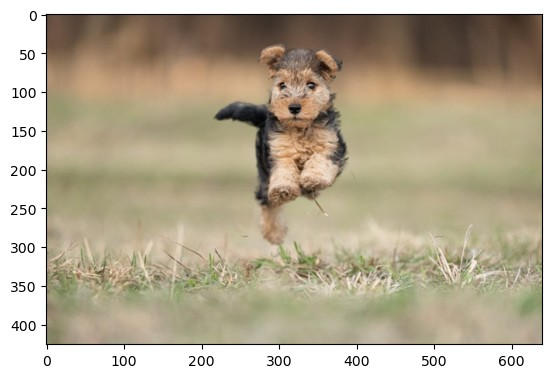

In [5]:
im = PIL.Image.open(ipnb_base + "картинка.jpg")
fig, ax = plt.subplots()
ax.imshow(im)
plt.show()

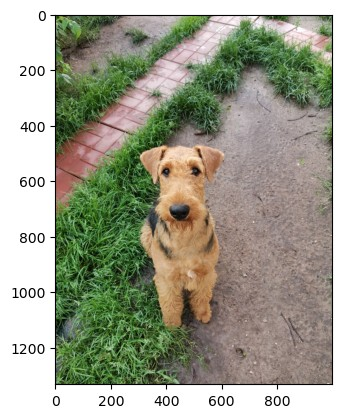

In [6]:
im1 = PIL.Image.open(ipnb_base + "картинка-1.png")
fig, ax = plt.subplots()
ax.imshow(im1)
plt.show()

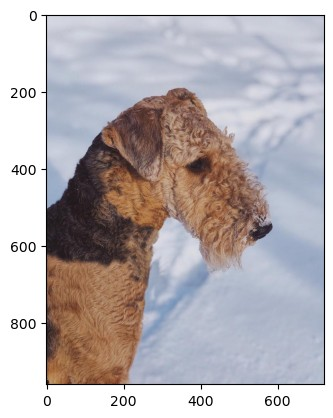

In [7]:
im2 = PIL.Image.open(ipnb_base + "картинка-2.tiff")
fig, ax = plt.subplots()
ax.imshow(im2)
plt.show()

### Проверка за видео ролик

In [8]:
# start_time = 2.*60. + 59.
# cap = cv2.VideoCapture(ipnb_base + 'ролик.mp4')
# frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# fps = cap.get(cv2.CAP_PROP_FPS)
# start_frame_number = int(start_time*fps)
# assert start_frame_number < frame_count
# cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
# ret, frame = cap.read()
# assert ret
# imv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# fig, ax = plt.subplots()
# ax.imshow(imv)
# plt.show()

# Загрузка с Яндекс Диск

Здесь вариантов меньше, к тому проблем с типом содержимого быть не
должно.

В описании [Яндекс Диск — REST API - Операции над опубликованными
файлами и папками](https://yandex.ru/dev/disk-api/doc/ru/reference/public)
написано, что OAuth-токен (и, соответственно, заголовок Authorization)
в таких запросах указывать не нужно.

Вариант, когда публикуется папка, а записка выбирает файлы из неё,
кажется более естественным, по крайней мере, нет необходимости 
контроля имени файла.

In [9]:
yd_base_url = (
    "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    "?public_key=")
yd_ipnb_dir = "tmp/yd"
yd_ipnb_depends = [
    ('https://disk.yandex.ru/d/fuLULT5qkoKZe',
     'README-utf8.txt'),
    ('https://disk.yandex.ru/d/s0xAFZPSxsLPJw',
     'Снимок экрана 2016-03-01 в 20.03.48.png'),
    ('https://disk.yandex.ru/d/D1dE3pBw8xuD3g',
     'i64-15_17-19.txt.bz2'),
]

st = time.time()
os.makedirs(yd_ipnb_dir, exist_ok=True)
with requests.Session() as session:
    for ypk, yp in yd_ipnb_depends:
        fp = yd_ipnb_dir + "/" + yp
        print(f"Пробуем: {fp} - ", end="")
        api_url = yd_base_url + ypk + "&path=/" + yp
        response = session.get(api_url)   
        download_url = response.json()['href']
        download_response = session.get(download_url, stream=True)
        idp = id_yandex_disk(download_response.headers)
        if os.path.exists(fp) and id_check(fp, idp):
            print("совпадает id")
        else:
            id_unlink(fp)
            print("загрузка - ", end="")
            try:
                with open(fp, 'wb') as f:   
                     f.write(download_response.content)
                id_create(fp, idp)
            except Exception as ex:
                id_unlink(fp)
                raise ex
            print("хорь")
print(f"Хорь {time.time() - st:.2f}")
# requests.Session() - 3.6 .. 6.7

Пробуем: tmp/yd/README-utf8.txt - совпадает id
Пробуем: tmp/yd/Снимок экрана 2016-03-01 в 20.03.48.png - совпадает id
Пробуем: tmp/yd/i64-15_17-19.txt.bz2 - совпадает id
Хорь 2.98
